In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/ENF-WHU-Dataset/H1')
sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')
from ENF_preprocessing import downsampling, bandpass_filter, cut_tones
from ENF_frequency_phase_estimation import segmented_phase_estimation_DFT0, phase_estimation_DFT0
from Rodriguez_Audio_Authenticity import feature, Lambda, lambda_accuracy

In [3]:
dir = '/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/ENF-WHU-Dataset/H1'
files = os.listdir(dir)
data = [f for f in files if f.endswith('.wav')]
signals = []
cut_signals = []


for wav_file in tqdm(data):
    file_path = os.path.join(dir, wav_file)
    fs, signal = wavfile.read(file_path)

    downsampled_sig = downsampling(signal, fs, f_ds=1000)
    bandpass_sig = bandpass_filter(downsampled_sig, 49.5, 50.5, 8000, 3)
    signals.append(bandpass_sig)

for signal in tqdm(signals):
    cut_signals.append(cut_tones(signal, 8000)[0])

#fs.append(wavfile.read(file_path)[0])
    #signals.append(wavfile.read(file_path)[1])

100%|██████████| 130/130 [00:00<00:00, 320.82it/s]


In [4]:
N_DFT = 20_000
NUM_CYCLES = 10
F_uncut = []
F_cut = []

for sig in tqdm(signals):
    F = feature(segmented_phase_estimation_DFT0(sig, 8000, NUM_CYCLES, N_DFT, 50))
    F_uncut.append(F)

for sig in tqdm(cut_signals):
    F = feature(segmented_phase_estimation_DFT0(sig, 8000, NUM_CYCLES, N_DFT, 50))
    F_cut.append(F)

100%|██████████| 130/130 [01:43<00:00,  1.25it/s]


In [5]:
# Labels: 0 for class 1, 1 for class 2
num_samples = len(signals)
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([F_uncut, F_cut])

Characterization probaility: 0.5576923076923077%


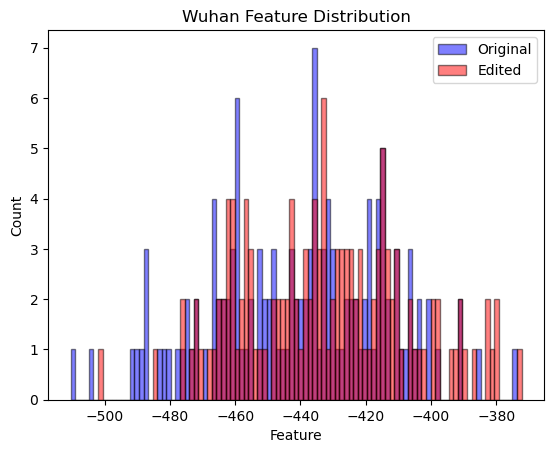

In [6]:
min_val = np.min(features)
max_val = np.max(features)
bins = np.linspace(min_val, max_val,100)

LAMBDA = Lambda(F_uncut, F_cut)
accuracy = lambda_accuracy(F_uncut, F_cut, LAMBDA)
print(f'Characterization probaility: {accuracy}%')

plt.hist(F_uncut, bins=bins,color='blue', alpha=0.5, edgecolor='black',label="Original")
plt.hist(F_cut, bins=bins, color='red', alpha=0.5, edgecolor='black', label="Edited")
#plt.axvline(LAMBDA, color="darkred", label=f"Lambda={LAMBDA:.3f}")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Wuhan Feature Distribution")
plt.legend(loc="best")
#plt.savefig("feature_WUHAN_clean_data")
plt.show()